# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system utilizes antibodes, and efforts to design antibodies that function more potently.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import brentq

from scipy.optimize import least_squares
from sklearn.model_selection import LeaveOneOut

np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    # Check that there is a solution
    if diffFunAnon(0) * diffFunAnon(Rtot) > 0:
        raise RuntimeError("There is no solution with these parameters. Are your inputs correct?")

    # Vector of binomial coefficients
    Req = brentq(diffFunAnon, 0, Rtot, disp=False)

    # Calculate vieq from equation 1
    vieq = L0*(1/Kd)*Req*(binom(v, np.arange(1, v + 1))) * np.power(Kx*Req, np.arange(v))

    # Calculate L, according to equation 7
    Lbound = np.sum(vieq)

    # Calculate Rmulti from equation 5
    Rmulti = np.sum(np.multiply(vieq[1:], np.arange(2, v + 1, dtype=np.float)))

    # Calculate Rbound
    Rbnd = np.sum(np.multiply(vieq, np.arange(1, v + 1, dtype=np.float)))
    
    StoneModOutputArray = [Lbound, Rbnd, Rmulti]
    
    return StoneModOutputArray

data = np.loadtxt("wk3-stone.csv", delimiter=",")

# Vector of the ligand concentrations, cell response (proportional to Rmulti), valencies
Xs, Ys, Vs = np.hsplit(data, 3)

Xs = np.squeeze(Xs)
Ys = np.squeeze(Ys)
Vs = np.squeeze(Vs)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

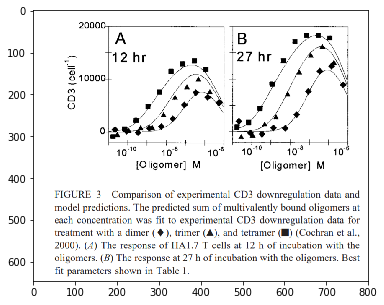

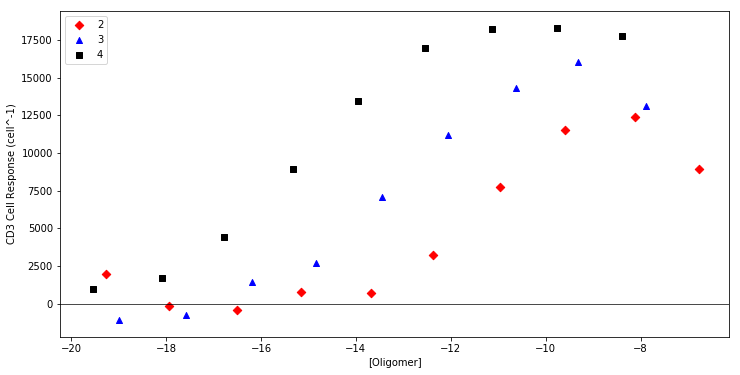

In [2]:
import matplotlib.image as mplimg
im_path = 'Fig3B.png'
fig = mplimg.imread(im_path)
plt.figure(figsize =(6,6));
plt.imshow(fig);

'''im_path = 'Table1.png'
fig2 = mplimg.imread(im_path)
plt.figure(figsize =(6,6));
#plt.imshow(fig2);'''

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(np.log(200*Xs[:10]),0.99*Ys[:10], marker='D', c='r') #dimers
plt.scatter(np.log(200*Xs[10:19]),0.99*Ys[10:19], marker='^', c='b') #trimers
plt.scatter(np.log(200*Xs[19:]),0.99*Ys[19:], marker='s', c='k') #tetramers
plt.xlabel('[Oligomer]')
plt.ylabel('CD3 Cell Response (cell^-1)')
plt.legend('2' '3' '4', loc= 2)
plt.axhline(color = 'k', linewidth = 0.7); # include line y = 0

As the valency increases, going from dimers to trimers and tetramers, the peak cell response increases and occurs at lower concentrations of oligomers. 
Kx and Kd are the same for all oligomers in Fig3B, but Kx and Kd are smaller for Fig3A, and the peak cell responses are also lower, indicating that Kx an Kd are positively correlated with cell response.

#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

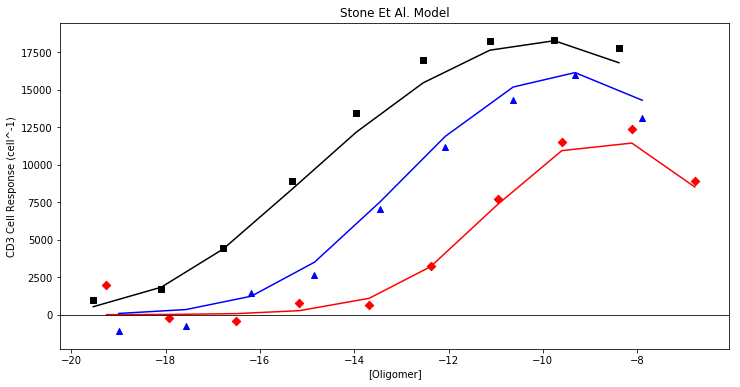

In [10]:
# Question 2.1
def InitialValues():
    Kd, Kx, Rtot = 1.7*10**-6, 3.15*10**-4, 24000 # from Stone et al
    Scale = 1
    return Kd, Kx, Rtot, Scale

def ModelFunction(Rtot, Scale, Kd, Kx, Xs, Vs):
    StoneModOutput = np.zeros((len(Xs), 3))
    for i in range(len(Xs)):
        for j in range(3):
            StoneModOutput[i, j] = StoneMod(Rtot, Kd, Vs[i], Kx, Xs[i])[j]
    Lbound, Rbnd, Rmulti = np.hsplit(StoneModOutput, 3)
    Lbound = np.squeeze(Lbound)
    Rbnd = np.squeeze(Rbnd)
    Ypredict = Scale * np.squeeze(Rmulti)

    return [Lbound, Rbnd, Ypredict]

def Plot_Model(Rtot, Scale, Kd, Kx, Xs, Vs):
    Ypredict = ModelFunction(Rtot, Scale, Kd, Kx, Xs, Vs)[2]

    # Plot
    fig, ax = plt.subplots(figsize=(12,6))

    ax.plot(np.log(200*Xs[:10]),Ypredict[:10], c='r') #dimer model
    plt.plot(np.log(200*Xs[10:19]),Ypredict[10:19], c='b') #trimer model
    plt.plot(np.log(200*Xs[19:]),Ypredict[19:], c='k') #tetramer model

    plt.scatter(np.log(200*Xs[:10]),0.99*Ys[:10], marker='D', c='r') #dimer data
    plt.scatter(np.log(200*Xs[10:19]),0.99*Ys[10:19], marker='^', c='b') #trimer data
    plt.scatter(np.log(200*Xs[19:]),0.99*Ys[19:], marker='s', c='k') #tetramer data
    plt.axhline(color = 'k', linewidth = 0.8) # include line y = 0
    plt.xlabel('[Oligomer]')
    plt.ylabel('CD3 Cell Response (cell^-1)');

Kd, Kx, Rtot, Scale = InitialValues()
Plot_Model(Rtot, Scale, Kd, Kx, Xs, Vs)
plt.title('Stone Et Al. Model');

#### (2) Now use `scipy.optimize.least_squares` to find the least squares solution.

Least Squares Model:
Kd = 1.702682e-06
Kx = 3.147275e-04
Scaling Factor = 1.028152


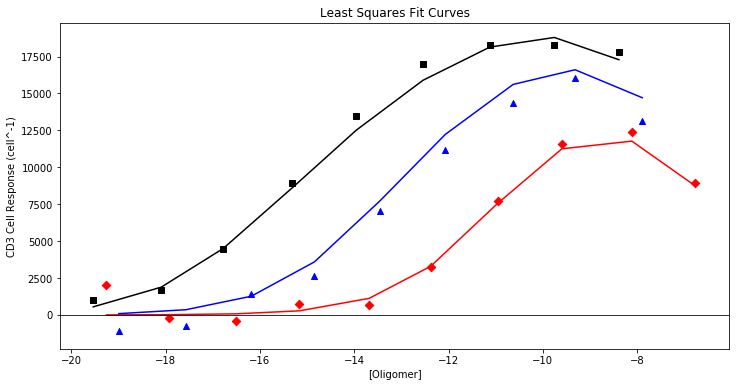

In [4]:
# Question 2.2
Kd, Kx, Rtot, Scale = InitialValues()

def Scaled_Ypredict(Rtot, Kd1, Vs, Kx1, Xs, Scale1, index3 = 2):
    Ypredict = np.zeros(len(Xs))
    for i in range(len(Xs)):
        Ypredict[i] = Scale1 * StoneMod(Rtot, Kd1, Vs[i], Kx1, Xs[i])[index3]
    return Ypredict
    
def Diff_Fun(X, Rtot, Vs, Xs, Ys, index2 = 2):
    Diff = Ys - Scaled_Ypredict(Rtot, X[0], Vs, X[1], Xs, X[2], index3 = index2)
    return Diff

def Fun_Least_Squares(Rtot, Kd, Vs, Kx, Xs, Ys, Scale, index = 2, **bounds):
    InitialGuess = [Kd, Kx, Scale]
    minBound = [0, 0, 0] # default minimum bound
    maxBound = [np.inf, np.inf, np.inf] # default maximum bound
    
    # Set custom bounds for 1 parameter
    minB, maxB, need_Index, k = 0, np.inf, False, np.nan # default bounds and default to not seek Index input
    for key, value in bounds.items():
        if key is 'Index': # get parameter index
            k = value
            if value > 2:
                raise RuntimeError("Index must be 0, 1, or 2")
        elif key is 'minBound': # override minimum bound
            minB, need_Index = value, True
        elif key is 'maxBound': # override maximum bound
            maxB, need_Index = value, True
        else:
            print('"{}" is not a variable in this function'.format(key))
    if need_Index == True:
        if np.isnan(k) == True:
            raise RuntimeError('To set custom bounds, please include the index of the desired bound parameter with keyword "Index"')
        else:
            minBound[k], maxBound[k] = minB, maxB

    # Run least squares  
    Res = least_squares(Diff_Fun, InitialGuess, bounds=(minBound, maxBound), args=(Rtot, Vs, Xs, Ys, index))
    return Res.x

[KdMod, KxMod, ScaleMod] = Fun_Least_Squares(Rtot, Kd, Vs, Kx, Xs, Ys, Scale)

# Results and Plot
print('Least Squares Model:\nKd = %e\nKx = %e\nScaling Factor = %f' % (KdMod, KxMod, ScaleMod))
Plot_Model(Rtot, ScaleMod, KdMod, KxMod, Xs, Vs)
plt.title('Least Squares Fit Curves');

#### (3) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

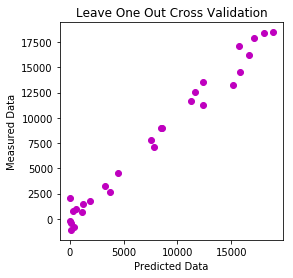

In [5]:
from sklearn.model_selection import LeaveOneOut
Kd, Kx, Rtot, Scale = InitialValues()
loo = LeaveOneOut()
YpredictLOO = np.zeros(28)

for train, test in loo.split(Xs):

    XsTrain = Xs[train]
    YsTrain = Ys[train]
    VsTrain = Vs[train]
    
    Res = Fun_Least_Squares(Rtot, Kd, VsTrain, Kx, XsTrain, YsTrain, Scale) # build least squares model on training data
    [KdTrain, KxTrain, ScaleTrain] = Res; # get least squares model into callable variables
    sclr_tst = np.asscalar(test)
    YpredictLOO[sclr_tst] = ScaleTrain * StoneMod(Rtot, KdTrain, Vs[sclr_tst], KxTrain, Xs[sclr_tst])[2] # predict 'test' with parameters from training data set

def Plot_Msmnt_vs_Prdct(YpredictLOO, Ys):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(YpredictLOO, Ys, color = 'm')
    plt.xlabel('Predicted Data')
    plt.ylabel('Measured Data');

Plot_Msmnt_vs_Prdct(YpredictLOO, Ys)
plt.title('Leave One Out Cross Validation');

Leave one out cross validation appears to predict the measured data well as the measured and predicted values are linearly related. Each value predicted with the training set (while excluding one test value) predicts the test value well.

#### (4) Using bootstrap estimation, plot the confidence interval of the model along with the data points.

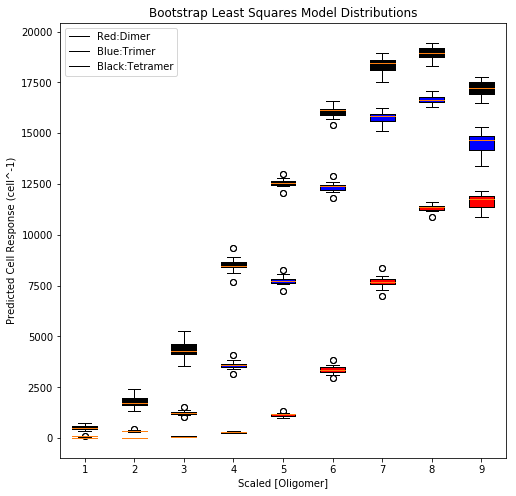

In [19]:
from sklearn.utils import resample
Kd, Kx, Rtot, Scale = InitialValues()

num_boots = 15
Xsi = np.linspace(0, 27, num = 28, dtype = int)
YpredictBoot = np.zeros((num_boots, len(Xs)))

for j in range(num_boots):
    resamp = resample(Xsi)
    XsResamp= Xs[resamp]
    YsResamp = Ys[resamp]
    VsResamp = Vs[resamp]

    Res = Fun_Least_Squares(Rtot, Kd, VsResamp, Kx, XsResamp, YsResamp, Scale) # build least squares model on training data
    [KdResamp, KxResamp, ScaleResamp] = Res; # get least squares model into callable variables

    YpredictBoot[j, :] = Scaled_Ypredict(Rtot, KdResamp, Vs, KxResamp, Xs, ScaleResamp) # fill all bootstrap models

# Plot    
def draw_plot(data, edge_color, fill_color): # copied from https://stackoverflow.com/questions/41997493/python-matplotlib-boxplot-color
    bp = ax.boxplot(data, patch_artist=True)
    for element in ['boxes']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

fig, ax = plt.subplots(figsize=(8,8))
draw_plot(YpredictBoot[:,:10], 'black', 'red')
draw_plot(YpredictBoot[:,10:19], 'black', 'blue')
draw_plot(YpredictBoot[:,19:], 'black', 'black')

ax.boxplot(YpredictBoot[:,:10]);
plt.boxplot(YpredictBoot[:,10:19]);
plt.boxplot(YpredictBoot[:,19:]);
plt.xlabel('Scaled [Oligomer]')
plt.ylabel('Predicted Cell Response (cell^-1)')
plt.title('Bootstrap Least Squares Model Distributions')
plt.legend(labels = ['Red:Dimer', 'Blue:Trimer', 'Black:Tetramer']);

This plot shows the distribution of predicted values based on resampling of input data.

#### (5) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

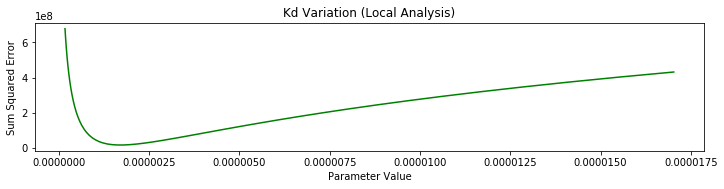

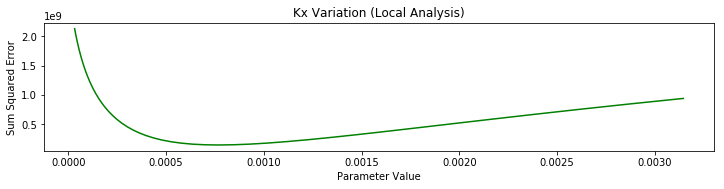

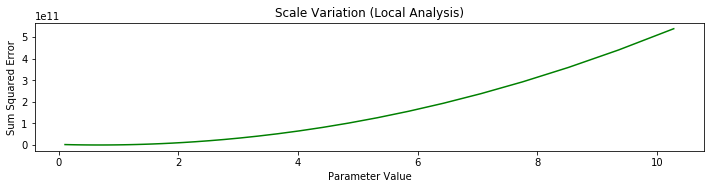

In [12]:
def Local_LS_Analysis(Vs, Xs, Ys, num_variations):
    Kd, Kx, Rtot, Scale = InitialValues() # initialize parameters

    # Build Least Squares Model
    Res = Fun_Least_Squares(Rtot, Kd, Vs, Kx, Xs, Ys, Scale) # build least squares model
    [KdModel, KxModel, ScaleModel] = Res; # get least squares model into callable variables

    SumSquaredError = np.zeros((num_variations, len(Res)))
    parScale = np.logspace(-1, 1, num = num_variations) # create vector with num_variations entries between 0.1 and 10

    # Vary parameters individually, keeping other two parameters at previous least squares solution
    for parTracker, parameter in enumerate(Res):
        for valuTracker, parVaried in enumerate(parScale*parameter):
            X = Res # set X as least squares model
            X[parTracker] = parVaried # permute changing parameter
            SumSquaredError[valuTracker, parTracker] = np.sum(np.square(Diff_Fun(X, Rtot, Vs, Xs, Ys))) # input sum of squared error into array

        # Plot
        fig = plt.figure(figsize=(12,8)) # set figure size
        ax = fig.add_subplot(3,1, parTracker + 1) # create 3 plots
        ax.plot(parScale*parameter, SumSquaredError[:, parTracker], color = 'g'); # plot varied parameter values versus Sum Squared Error
        ttl = ['Kd', 'Kx', 'Scale']
        plt.title('%s Variation (Local Analysis)' % ttl[parTracker])
        plt.xlabel('Parameter Value')
        plt.ylabel('Sum Squared Error');
        
num_variations = 50
Local_LS_Analysis(Vs, Xs, Ys, num_variations);

Scale appears to influence the fit the most because as its scale is 10^11, while the scale for Kx and Kd are 10^8 and 10^9 respectively. Kx appears to have the smallest affect because the slope on either side of the minimum is more gradual than Kd.

#### (6) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

A global analysis should build a better model, reducing the sum of squared error because least squares will compensate for the varied parameter.
I anticipate my predictions of parameter values will be less specified with a global analysis because for any given varied parameter, the other parameters will be varied by least squares to make as best a model as possible, reducing the sum of squared error.

#### (7) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when $K_d$ increases?

Hint: Probably the easiest way to do this is mess with the bounds of the least squares solver.

Kd, Kx, and Scale values when Kd is varied parameter
[1.70268182e-07 1.52377139e-04 1.16829271e+00]
[2.76477513e-07 1.55006717e-04 1.21729597e+00]
[4.48937755e-07 1.69152791e-04 1.21477037e+00]
[7.28974684e-07 1.99873180e-04 1.16473096e+00]
[1.18369213e-06 2.54411181e-04 1.08742169e+00]
[1.92205174e-06 3.38937384e-04 1.00982950e+00]
[3.12098290e-06 4.57653575e-04 9.47401505e-01]
[5.06777944e-06 6.12546167e-04 9.03302630e-01]
[8.22894237e-06 8.04457759e-04 8.74832021e-01]
[1.33619652e-05 1.03507951e-03 8.57939888e-01]


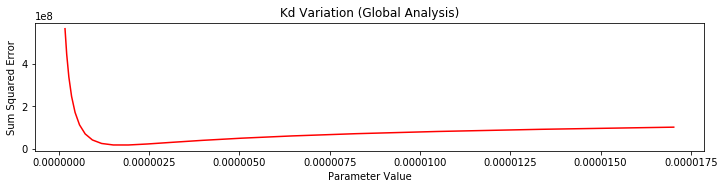

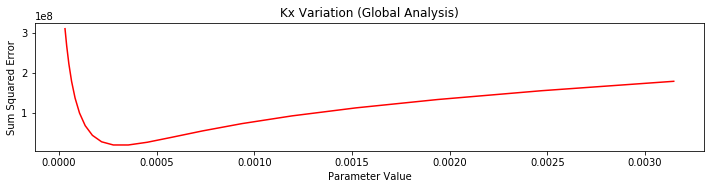

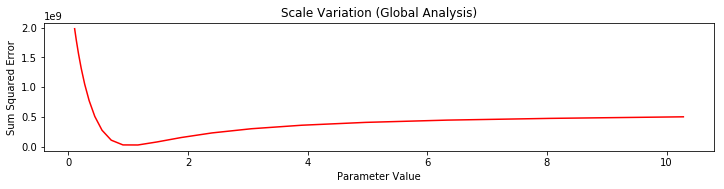

In [20]:
def Global_LS_Analysis(Vs, Xs, Ys, num_variations):
    Kd, Kx, Rtot, Scale = InitialValues()
    Res = Fun_Least_Squares(Rtot, Kd, Vs, Kx, Xs, Ys, Scale) # build least squares model
    [KdModel, KxModel, ScaleModel] = Res; # get least squares model into callable variables

    SumSquaredError = np.zeros((num_variations, len(Res)))
    parScale = np.logspace(-1, 1, num = num_variations) # create vector with num_variations entries between 0.1 and 10
    print('Kd, Kx, and Scale values when Kd is varied parameter')
    for parTracker, parameter in enumerate(Res):
        for valuTracker, parVaried in enumerate(parScale*parameter):
            if parTracker == 0:
                Kd = parVaried
            elif parTracker == 1:
                Kx = parVaried
            elif parTracker == 2:
                Scale = parVaried
            X = Fun_Least_Squares(Rtot, Kd, Vs, Kx, Xs, Ys, Scale, Index = parTracker, minBound = parVaried, maxBound = 1.00000001*parVaried) # build initial least squares model
            SumSquaredError[valuTracker, parTracker] = np.sum(np.square(Diff_Fun(X, Rtot, Vs, Xs, Ys))) # input sum of squared error into array
            if parTracker == 0 and (valuTracker % 2) == 0: # print parameters for even iterations:
                print(X)
        # Plot
        fig = plt.figure(figsize=(12,8)) # set figure size
        ax = fig.add_subplot(3,1, parTracker + 1) # create 3 plots
        ax.plot(parScale*parameter, SumSquaredError[:, parTracker], color = 'r'); # plot varied parameter values versus Sum Squared Error
        ttl = ['Kd', 'Kx', 'Scale']
        plt.title('%s Variation (Global Analysis)' % ttl[parTracker])
        plt.xlabel('Parameter Value')
        plt.ylabel('Sum Squared Error');
        
num_variations = 20
Global_LS_Analysis(Vs, Xs, Ys, num_variations);

My prediction was correct; my parameters are less specified. The scale of sum of squared error for Kd is decreased slightly, Kx is reduced by an order of magnitude, and the scale is reduced by 2 orders of magnitude. Additinally, on the right side of each minimum, the slope is flatter, indicating that the parameter can change significantly without increasing the sum of squared error too much.
Based on Figure 3 from Stone et. al, I would expect Kx and scale to decrease as Kd increases because Kd, Kx, and scale are all positively correlated with cell response. If Kd increases, Kx and scale should decrease to maintain a good model of cell response. This is partially supported by my printed Kd, Kx, and Scale values when Kd was varied. As Kd increases, Kx has a net decrease while scale fluxuates with a net increase.

#### (8) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters. Are these more or less exactly specified than Rmulti? *In general*, which sort of quantities do you think will be most exactly predicted?

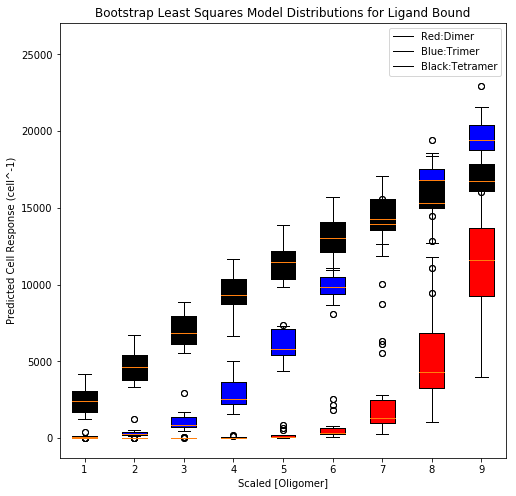

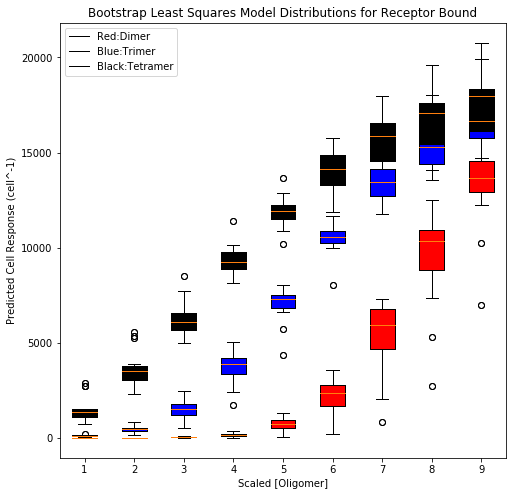

In [9]:
for p in [0,1]:
    Kd, Kx, Rtot, Scale = InitialValues()

    num_boots = 15
    Xsi = np.linspace(0, 27, num = 28, dtype = int)
    YpredictBoot = np.zeros((num_boots, len(Xs)))
    YpredictAv = np.zeros(num_boots)

    for j in range(num_boots):
        resamp = resample(Xsi)
        XsResamp= Xs[resamp]
        YsResamp = Ys[resamp]
        VsResamp = Vs[resamp]

        Res = Fun_Least_Squares(Rtot, Kd, VsResamp, Kx, XsResamp, YsResamp, Scale, index = p) # build least squares model on training data
        [KdResamp, KxResamp, ScaleResamp] = Res; # get least squares model into callable variables

        YpredictBoot[j, :] = Scaled_Ypredict(Rtot, KdResamp, Vs, KxResamp, Xs, ScaleResamp, index3 = p) # fill all bootstrap models

    # Plot    
    fig, ax = plt.subplots(figsize=(8,8))
    draw_plot(YpredictBoot[:,:10], 'black', 'red')
    draw_plot(YpredictBoot[:,10:19], 'black', 'blue')
    draw_plot(YpredictBoot[:,19:], 'black', 'black')

    ax.boxplot(YpredictBoot[:,:10]);
    plt.boxplot(YpredictBoot[:,10:19]);
    plt.boxplot(YpredictBoot[:,19:]);

    ttl = ['Ligand Bound', 'Receptor Bound']
    plt.xlabel('Scaled [Oligomer]')
    plt.ylabel('Predicted Cell Response (cell^-1)')
    plt.title('Bootstrap Least Squares Model Distributions for %s' %ttl[p])
    plt.legend(labels = ['Red:Dimer', 'Blue:Trimer', 'Black:Tetramer']);

The distributions for ligand and receptor bound are much larger than for Rmulti. Both the boxes and whiskers are much larger, and the while the dimer(red), trimer(blue), and tetramer(black) maintain their relative hierarchy, their distributions begin to overlap at high oligomer concentrations. These values are thus less specified than Rmulti. In general, I expect that parameters with high correlation to cell response (Ys) should be better predictors and more specified than parameters with lower correlation.

#### (9) Other quantities such as the number of bound receptors may be possible to measure as well. Describe how you would go about fitting this data along with the multimerized receptor measurements. How might more measurements of different types be better than more measurements of the same type?

To fit bound receptors alongside Rmulti, we could add bound receptors to our original data matrix as another column, just like we had Vs for the valency. We were previously modeling both Rmulti and valency, and now bound receptors would just be another variable in our modeling. We would still produce one prediction of cell response for each data row to compare to our measured cell response to build our model.
Having different types of data is better than more measurements of one data type because there could be flaws in the collection method of one measurement, and having multiple measurement types increases the likelihood that we are feeding the model all the parameters that affect the prediction.